# Sampling from Truncated Distributions [1] 

Truncated distributions arise quite naturally in inequality constrained regression. Consider the following example where some noisy measurements ($y$) are shown as a function of time ($t$).

We first load all required Python modules. The *cvxpy* package is a package for convex optimization. Instructions to install it can be found here: https://www.cvxpy.org/ . The *truncsample* package is a package I created myself to test out different samplers. It also include the Python notebooks used to create this series of blog posts and can be found here: https://gitlab.com/krisvillez/truncsample . The remaining packages are pretty standard I suspect.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
import cvxpy as cvx
from os import path
import sys

sys.path.append(path.abspath(path.join(path.abspath('') ,"../../truncsample")))

from truncsample.tmvn import truncmvn

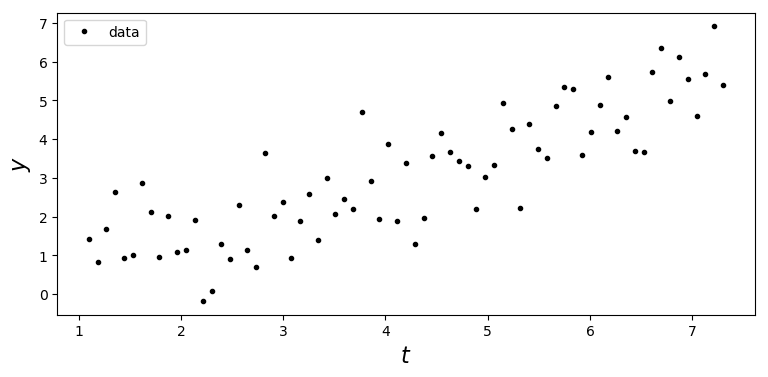

In [2]:
a = 0.11
b = 0.73

t_ = np.linspace (1.1,7.3,73)
y_ = a + b*t_
ytil_ = y_ + norm.rvs(loc=0, scale=1, size=len(y_), random_state=42)

fig = plt.figure(figsize=(9,4),dpi=100)
ax = fig.gca()
h1, = plt.plot(t_,ytil_,'k.',label='data');
ax.set_xlabel('$t$', fontsize=16)
ax.set_ylabel('$y$', fontsize=16)
plt.legend(handles=[h1]);

Suppose now that we know that the data was produced as a linear trend plus noise with the additional piece of knowledge that this trend line is positive and increasing over the considered time window. In this case, we can compute an estimate of the trend line as the best least-squares approximation of the data satisfying the positivity and increasing property. This estimated trend line is shown next:

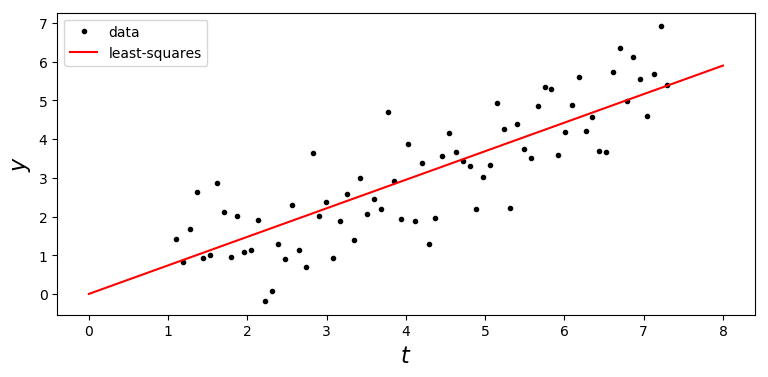

In [3]:
beta =   cvx.Variable (2)
dev  =   cvx.Variable (len(ytil_))
constraints  =   [  ( t_*beta[1]  +  beta[0] - ytil_ ) ==  dev , beta[0]>=0 , beta[1]>=0 ]
prob         =   cvx.Problem (cvx.Minimize (cvx.pnorm (dev, p=2)) , constraints)
prob.solve ()
betahat        =   beta.value
        
that_ = np.linspace (0,8,321)
yhat_ = betahat[0] + betahat[1]*that_


fig = plt.figure(figsize=(9,4),dpi=100)
ax = fig.gca()
h1, = plt.plot(t_,ytil_,'k.',label='data');
h2, = plt.plot(that_,yhat_,'r-',label='least-squares');
ax.set_xlabel('$t$', fontsize=16)
ax.set_ylabel('$y$', fontsize=16)
plt.legend(handles=[h1,h2]);

### Inequality constrained regression - Likelihood

So far so good. Now consider that we want to use this type of model to estimate the expected value and an uncertainty band around it at time $t=0.5$. 

This is where a truncated distribution comes in handy. More precisely, the likelihood of the inequality constrained regression parameters can be described as follows:

$L(a,b) = H(a) \cdot H(b) \cdot    \left( -N / 2\cdot \ln{(2 \pi)}   - N / 2\cdot  \ln{(\sigma^2)} - 1/2 \cdot \sum_{i} \, \left( \left( a + b \, t_i - y_i \right)/\sigma  \right)^2  \right)$

where:

* $a$ and $b$ are the intercept and slope of the trend line

* $H(a)$ is the heaviside function, which is 1 when $a \geq 0$ and 0 otherwise

* $t_i$ and $y_i$ are the $N$ measurement samples consisting of a time and a measurement

* $\sigma$ is the measurement error standard deviation

In this case, we assume that we know that $\sigma=1$. The next figure shows the likelihood function as a contour plot. The red dot corresponds to the constrained regression line we found above. This is the point in the parameter space with maximum likelhood.

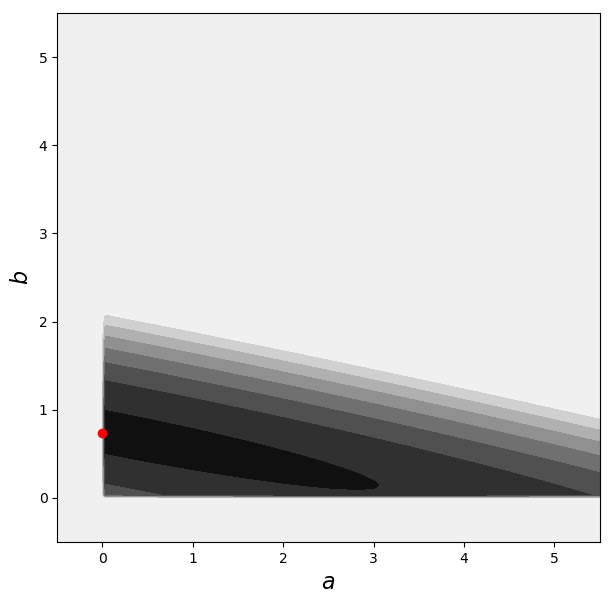

In [4]:
a = np.linspace(-.5,+5.5,150);
b = np.linspace(-.5,+5.5,150);

na = len(a)
nb = len(b)
N =len(y_)
sigpar = 1 
L = np.zeros([nb,na])
for ia in range(0,na):
    for ib in range(0,nb):
        if (a[ia]<0) | (b[ib]<0):
            L[ib,ia]= 0
        else :
            L[ib,ia]=  np.exp(-sum( (a[ia] + b[ib]*t_ -y_)**2 )/(2*sigpar*N) - 1/2*np.log(2*np.pi) - 1/2*np.log(sigpar**2) ) 
        
cmap = plt.cm.get_cmap("gray")

fig = plt.figure(figsize=(7,7),dpi=100)
ax = fig.gca()
ax.contourf(a, b,-np.log(L*5+1e-9),7,cmap=cmap)
plt.plot(betahat[0],betahat[1],'ro')
ax.set_xlabel('$a$', fontsize=16)
ax.set_ylabel('$b$', fontsize=16)
ax.set_xlim((-0.5, +5.5))
ax.set_ylim((-0.5, +5.5))
plt.show()

One can see why working with a traditional multivariate distribution will not work. The density is clearly cut off rather abruptly at the edges of the region where both $a$ and $b$ are positive. Instead, we will work with the truncated density shown above. 

### Inequality constrained regression - Inference

Unfortunately, working with the truncated multivariate normal distributions is not as easy as working with its unconstrained version. To compute the expected mean, we need to integrate over the truncated density. There are several numerical methods available for this. In this series of blog posts, I will focus on Monte Carlo sampling methods. I chose these because they can be applied to more complex models as well (with more parameters). There are alternative methods (e.g., quadrature) but these appear harder to use when the number of parameters becomes large.

In essence, Monte Carlo sampling works as follows to compute the expected mean at $t=0.5$:

1. We sample a number, $M$, of parameter sets from the (truncated) density. The elements of $j$th parameter set are called $a[j]$ and $b[j]$ .

2. With each $j$th parameter set, compute a prediction $y_t[j]=y_{0.5}[j]$ for $t=0.5$: $y[j]=a[j] + 0.5 \, b[j]$ .

3. Compute the expected value for $y$ at $t=0.5$ as the average of the obtained predictions: $E\left[y\right]=\frac{1}{M} \sum_{j} y[j]$ .

The next figure shows $M=10000$ sampled parameter sets obtained in the first step. Details on how this is executed will follow in a next post. The figure also shows the mean parameter vector as purple dot. It is fairly easy to see that this mean  (purple dot) does not correspond to the maximum likelihood solution (red dot).

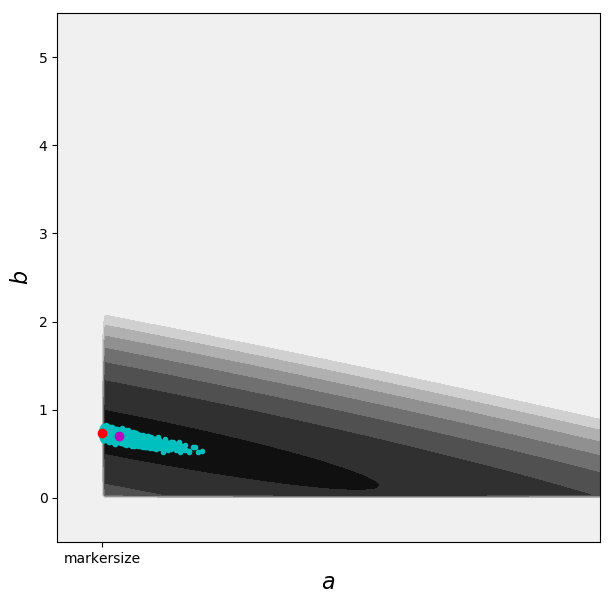

In [5]:
T_ = np.append(np.ones([N,1]),t_[:,None],1)
np.shape(T_)
beta0 = np.linalg.pinv(T_).dot(ytil_)
beta0_cov = np.linalg.inv(T_.T.dot(T_))
beta0 = beta0_cov.dot(T_.T.dot(ytil_))
np.shape(beta0)

M = 10000
burnin =1000
cov = True 

F       =   np.array([[1,0],[1,0]])
g       =   np.array([1,1])*0
beta_start = np.array([+2,+2.1])

TMVN = truncmvn(beta0, beta0_cov, F, g, cov)
TMVN.getmode()

beta_samples,bounce = TMVN.sample(M+burnin,beta_start,sampler="hmc")

beta_mean = np.mean(beta_samples,axis=1)

fig = plt.figure(figsize=(7,7),dpi=100)
ax = fig.gca()
ax.contourf(a, b,-np.log(L*5+1e-9),7,cmap=cmap)
plt.plot(beta_samples[0,burnin:],beta_samples[1,burnin:],'c.','markersize',1)
plt.plot(betahat[0],betahat[1],'ro')
plt.plot(beta_mean[0],beta_mean[1],'mo')
ax.set_xlabel('$a$', fontsize=16)
ax.set_ylabel('$b$', fontsize=16)
ax.set_xlim((-0.5, +5.5))
ax.set_ylim((-0.5, +5.5))
plt.show()

We now use these sampled parameter sets to compute expected mean value for $y$ at a range of values for $t$ with step 2 and 3 of the procedure above. The mean value at $t=0.5$ is highlighted with a dot in the next figure. The figure also shows the least-squares estimate we obtained before.

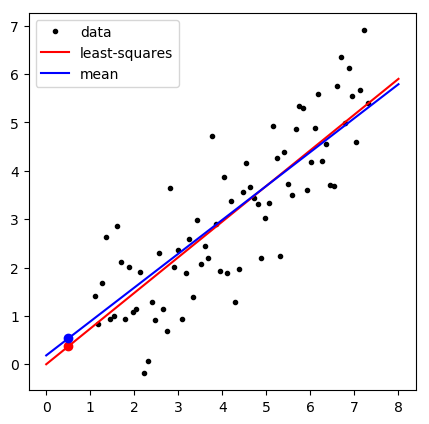

In [6]:
That_ = np.append(np.ones([len(that_),1]),that_[:,None],1)

y_samples = That_.dot(beta_samples[:,burnin:])
ybar_ = np.mean(y_samples,axis=1)

index = np.where(that_==.5)

fig = plt.figure(figsize=(5,5),dpi=100)
h1, = plt.plot(t_,ytil_,'k.',label='data');
h2, = plt.plot(that_,yhat_,'r-',label='least-squares');
h3, = plt.plot(that_,ybar_,'b-',label='mean');
plt.plot(that_[index],yhat_[index],'ro');
plt.plot(that_[index],ybar_[index],'bo');
ax.set_xlabel('$t$', fontsize=16)
ax.set_ylabel('$y$', fontsize=16)
plt.legend(handles=[h1,h2,h3]);
plt.show()

One can see that these two predictions are not the same. This is because the mode (least-squares solution) of a truncated multivariate normal distribution is not equal to its mean. This is unlike the case for multivariate distributions without truncation.

Another, and possibly more interesting, type of inference is the computation of uncertainty intervals. The following plot shows the 0.5% and 99.5% quantiles of the predictions as a function of time together with the median. From this figure we can see the distributions of these predictions are not symmetric, especially for low values for $t$.

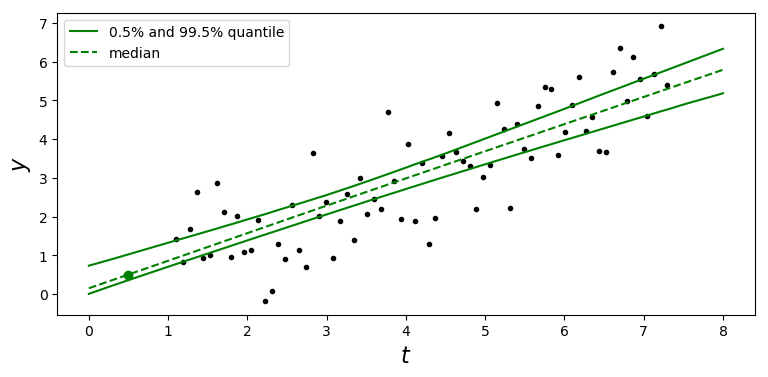

In [7]:
fig = plt.figure(figsize=(9,4),dpi=100)
ax = fig.gca()
plt.plot(t_,ytil_,'k.');
y_uncbnd = np.quantile(y_samples, (.005,.5,.995), axis=1) 
h1, = plt.plot(that_,y_uncbnd[0,:],'g-',label='0.5% and 99.5% quantile');
h2, = plt.plot(that_,y_uncbnd[1,:],'g--',label='median');
h3, = plt.plot(that_,y_uncbnd[2,:],'g-');
plt.plot(that_[index],y_uncbnd[1,index],'go');
ax.set_xlabel('$t$', fontsize=16)
ax.set_ylabel('$y$', fontsize=16);
plt.legend(handles=[h1,h2]);
plt.show()

The next figure shows the histogram of predictions for $y$ at time $t=0.5$. The vertical line shows the mean prediction. Here we see even more clearly that the predictive distribution is asymmetric. This property is also known as skewness.

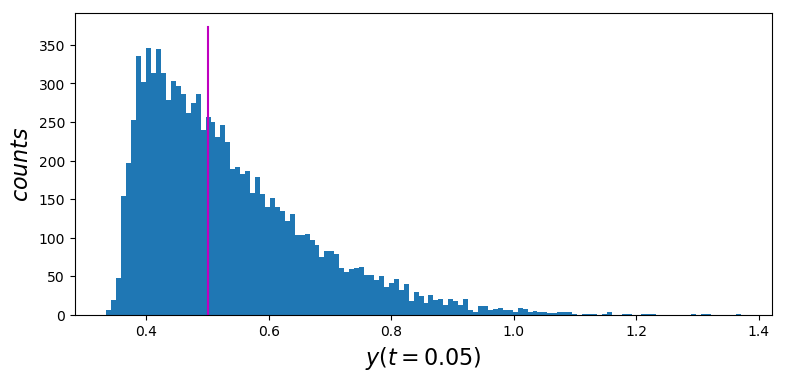

In [8]:
fig = plt.figure(figsize=(9,4),dpi=100)
ax = fig.gca()
y05_=(y_samples[np.where(that_==0.5)[0],:])[0,:]
y05_ = np.sort(y05_)
plt.hist(y05_,bins=128);
xL=y_uncbnd[1,index]*np.ones([2,1])
yL=np.array([0,373.0])
plt.plot(xL,yL,'m-');
ax.set_xlabel('$y(t=0.05)$', fontsize=16)
ax.set_ylabel('$counts$', fontsize=16);
plt.show()

### Take home message

This concludes the first post on truncated distributions:

* The main aim was to showcase a toy model where truncation of the parameter distribution is relevant. 

* In inequality constrained regression models, the mean parameter set does not correspond to the mode of the parameter distribution and predictive distributions can exhibit a decent amount of skewness. 

* Inferring the distribution of the parameters or model predictions requires numerical methods, such as (but not limited to) Monte Carlo sampling methods.